<a href="https://colab.research.google.com/github/sugarlin1732/RNN_Drug_property-/blob/main/04_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
import random
import numpy as np
np.set_printoptions(threshold=np.inf)
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [ ]:
# connect to google drive
from google.colab import  drive
drive.mount('/content/drive')
# change work dir
path = '/content/drive/My Drive/Drug_RNN'
os.chdir(path)

Mounted at /content/drive


In [ ]:
# read data
pd.set_option('display.max_columns', None)
col_name = ['MW', 'SMILES'] ## MW data

data = pd.read_table('./learning_data.txt',header=None,sep='\t', names=col_name)

# delete data without MW
# MW as label, SMILES as feature
data = data[['SMILES', 'MW']]
data['MW'] = pd.to_numeric(data['MW'], errors = 'coerce')
data.dropna(inplace = True)

data = shuffle(data)

x_train ,x_test, y_train, y_test = train_test_split((data['SMILES']), (data['MW'].astype(float)),test_size=0.1)
Y_train = y_train.values
Y_test = y_test.values

In [ ]:
print(data['SMILES'][0])

CC(=O)OC(CC(=O)[O-])C[N+](C)(C)C


In [ ]:
# dic for elements
import re
tmp = (''.join(list(data['SMILES']))+'!$')
elemset = set(re.compile(r'[^a-z][a-z]*').findall(tmp))
char_to_int = dict((c,i+1) for i,c in enumerate(elemset))
int_to_char = dict((i+1,c) for i,c in enumerate(elemset))
max_len = max([len(smile) for smile in data['SMILES']]) + 5
print(len(elemset), max_len)
print(char_to_int)
print(int_to_char)

98 998
{'At': 1, 'H': 2, '-': 3, 'Pd': 4, 'Sr': 5, 'Al': 6, 'Bi': 7, 'Te': 8, 'Cr': 9, 'V': 10, 'C': 11, 'Eu': 12, '9': 13, '0': 14, 'B': 15, ')': 16, '8': 17, 'Ag': 18, '3': 19, 'Nd': 20, 'Ir': 21, 'Lu': 22, 'Mn': 23, 'Zn': 24, 'Ba': 25, '#': 26, 'Dy': 27, 'Hg': 28, 'S': 29, 'Cs': 30, '.': 31, 'Cu': 32, 'Sc': 33, '6': 34, '7': 35, 'Yb': 36, 'Ce': 37, 'In': 38, 'As': 39, '2': 40, 'Cl': 41, 'Ti': 42, 'Ru': 43, 'Cm': 44, 'Sn': 45, 'Au': 46, 'Pr': 47, 'La': 48, 'Ca': 49, 'Mg': 50, 'Tl': 51, '4': 52, 'W': 53, 'I': 54, 'Co': 55, 'Cd': 56, 'Nb': 57, 'Ge': 58, '+': 59, 'Si': 60, '5': 61, 'P': 62, '!': 63, '1': 64, 'Os': 65, 'Li': 66, '$': 67, 'Re': 68, 'N': 69, '(': 70, 'F': 71, 'Pt': 72, 'Ga': 73, '%': 74, 'Sm': 75, '[': 76, 'Mo': 77, 'Rb': 78, 'Be': 79, 'Br': 80, 'Fe': 81, 'O': 82, 'Tc': 83, 'Hf': 84, 'Na': 85, 'Pu': 86, 'Zr': 87, 'Gd': 88, 'Y': 89, 'Sb': 90, 'K': 91, '=': 92, 'Ni': 93, ']': 94, 'U': 95, 'Se': 96, 'Rh': 97, 'Pb': 98}
{1: 'At', 2: 'H', 3: '-', 4: 'Pd', 5: 'Sr', 6: 'Al', 7: '

In [ ]:
'''
# dic for character
# char to int / int to char
# '!' for start char, '$' for end char, ''
charset = set(''.join(list(data['SMILES']))+'!$')
char_to_int = dict((c,i+1) for i,c in enumerate(charset))
int_to_char = dict((i+1,c) for i,c in enumerate(charset))
max_len = max([len(smile) for smile in data['SMILES']]) + 5
# print(str(charset))
print(len(charset), max_len)
print(char_to_int)
print(int_to_char)
'''

{']', 'L', 'C', 'S', '[', 'I', '7', 'y', '0', 'U', 'u', 'b', '$', '!', '6', 'l', 't', 'P', '#', 'Z', 'e', 'o', 'T', '1', '(', '=', '-', 'h', '8', 'V', ')', 'D', 'g', '+', 'F', 'H', 'W', 'N', 'Y', '9', '2', 'B', 'c', 'R', '%', 'i', 'd', 'E', 'G', 'n', 'A', 'M', 's', 'O', '4', '.', 'a', 'r', 'K', 'm', '5', '3', 'f'}


In [ ]:
# SMILES data char to int
def CtoI(smiles):
    int_smile = np.zeros((smiles.shape[0], max_len),dtype=np.int8)
    for i, s in enumerate(smiles):
        for j, e in enumerate(re.compile(r'[^a-z][a-z]*').findall(s)):
            int_smile[i, j] = char_to_int[e]
    return int_smile
X_train = CtoI(x_train.values)
X_test = CtoI(x_test.values)


In [ ]:
# import tf.keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, BatchNormalization, \
                                    Conv1D, LSTM, GRU, Dropout, concatenate, \
                                    Bidirectional, Masking, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow import config



In [ ]:
print(X_train.shape)
print(len(char_to_int))
print((Y_train[0]))

(70395, 998)
98
226.28


In [ ]:
# build model
dropout_rate = 0.2

input = Input(shape=X_train.shape[1:], name='Input')
embedding_layer = Embedding(input_dim=len(char_to_int)+1, output_dim=30, \
                            input_length=X_train.shape[1], embeddings_initializer='Orthogonal', \
                            mask_zero=True, name='Embedding_layer')(input)

lstm_layer = Bidirectional(LSTM(units=128, name='Bi_LSTM'))(embedding_layer)
# gru_layer = Bidirectional(GRU(units=128, name='Bi_GRU'))(embedding_layer)

dropout_lstm = Dropout(rate=dropout_rate, name='LSTM_Dropout')(lstm_layer)
# dropout_gru = Dropout(rate=dropout_rate, name='GRUDropout')(gru_layer)

# concate_cnn_lstm_gru = concatenate([dropout_lstm, dropout_gru], name='Concate')

############################################
#dense_out = Dense(units=512, activation='relu', name='Dense_out')(concate_cnn_lstm_gru)
dense_out = Dense(units=512, activation='relu', name='Dense_out')(dropout_lstm)
############################################
output_layer = Dense(units=1, activation='relu', name='Output')(dense_out)

model = Model(inputs=input, outputs=output_layer)
model.compile(
    loss='mse',
    optimizer='adam')
model.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 998)]             0         
_________________________________________________________________
Embedding_layer (Embedding)  (None, 998, 30)           2970      
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               162816    
_________________________________________________________________
LSTM_Dropout (Dropout)       (None, 256)               0         
_________________________________________________________________
Dense_out (Dense)            (None, 512)               131584    
_________________________________________________________________
Output (Dense)               (None, 1)                 513       
Total params: 297,883
Trainable params: 297,883
Non-trainable params: 0
________________________________________________

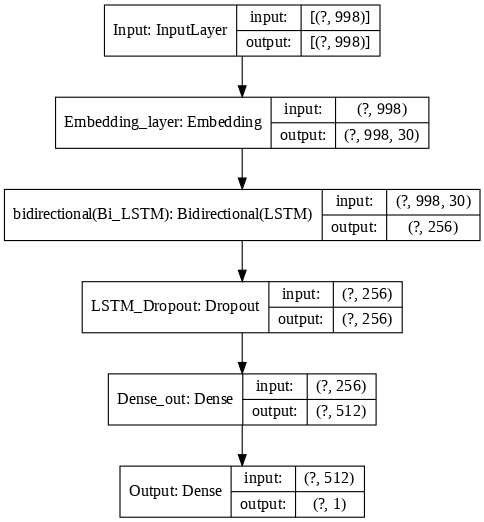

In [ ]:
# model visualization
plot_model(model, show_shapes=True, dpi=80)

In [ ]:
# Using the EarlyStopping of callback function to avoid meaningless learning
ES_function = EarlyStopping(monitor='val_loss', patience=10, verbose=1, \
                            min_delta=1e-9, mode='auto')

# Using the ReduceLROnPlateau of callback function to auto-control learning rate
LR_function = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, \
                                factor=0.2, min_lr=1e-6, mode='auto')


In [ ]:
# train model
history = model.fit(
    x=X_train, 
    y=Y_train, 
    epochs=300, 
    batch_size=64, 
    validation_split=0.1,
    shuffle=True)


Epoch 1/300
990/990 [==============================] - 35s 36ms/step - loss: 26631.3008 - val_loss: 8477.2783
Epoch 2/300
990/990 [==============================] - 34s 34ms/step - loss: 8275.6719 - val_loss: 7055.4917
Epoch 3/300
990/990 [==============================] - 33s 34ms/step - loss: 5859.9292 - val_loss: 7994.0986
Epoch 4/300
990/990 [==============================] - 33s 34ms/step - loss: 5437.5083 - val_loss: 1940.1926
Epoch 5/300
990/990 [==============================] - 34s 34ms/step - loss: 3709.4353 - val_loss: 8941.2129
Epoch 6/300
990/990 [==============================] - 34s 34ms/step - loss: 14752.0234 - val_loss: 4752.5864
Epoch 7/300
990/990 [==============================] - 34s 34ms/step - loss: 12778.0859 - val_loss: 6633.8574
Epoch 8/300
990/990 [==============================] - 33s 34ms/step - loss: 3686.8450 - val_loss: 1655.0135
Epoch 9/300
990/990 [==============================] - 33s 34ms/step - loss: 4517.5215 - val_loss: 1011.9973
Epoch 10/300
990

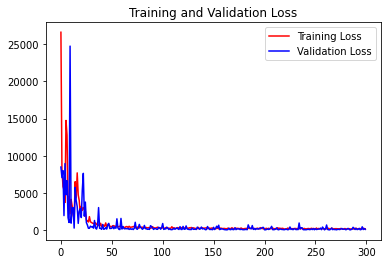

In [ ]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss=history.history['val_loss']


#epochs=range(ES_function.stopped_epoch+1)

plt.plot(list(range(len(loss))),loss,'r-',label='Training Loss')
plt.plot(list(range(len(val_loss))),val_loss,'b-',label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
test_result = model.predict(X_test)
for i in range(len(X_test)):
    print(test_result[i], Y_test[i])

串流輸出內容已截斷至最後 5000 行。
[433.75226] 434.3
[583.6856] 587.7
[893.4278] 906.2
[396.233] 396.5
[187.3382] 184.66
[1303.4639] 1324.0
[346.6772] 346.4
[343.074] 342.3
[424.60675] 429.5
[717.76355] 720.8
[91.001396] 87.16
[305.25037] 304.5
[391.09656] 391.8
[554.841] 556.6
[474.49017] 479.4
[345.4629] 345.4
[316.246] 315.28
[405.25967] 406.5
[341.73367] 340.4
[415.15378] 416.4
[213.90553] 212.28
[620.9715] 625.8
[279.88245] 280.14
[544.17126] 546.7
[213.66977] 212.14
[576.0386] 578.7
[363.26755] 361.9
[196.63452] 194.23
[214.43007] 212.29
[175.08023] 172.33
[286.34897] 288.27
[428.50235] 430.3
[202.72453] 200.28
[535.52625] 537.9
[232.19826] 229.66
[469.28537] 472.6
[1061.563] 1073.0
[340.29172] 340.4
[252.62599] 250.33
[116.11504] 107.1
[376.10327] 376.5
[339.1948] 338.3
[380.54605] 381.5
[214.23592] 211.64
[425.51157] 426.3
[971.1318] 981.2
[263.07336] 262.09
[351.41458] 352.5
[249.48267] 246.21
[500.401] 500.5
[298.84457] 298.33
[120.264496] 115.56
[849.84625] 854.9
[374.33954] 374.5
[362.13

In [ ]:
# # trun SMILES into one-hot code
# def vectorize(smiles):
#         one_hot =  np.zeros((smiles.shape[0], max_len, len(charset)),dtype=np.int8)
#         for i, smile in enumerate(smiles):
#             #encode the startchar
#             one_hot[i,0,char_to_int['!']] = 1
#             #encode the rest of the chars
#             for j, c in enumerate(smile):
#                 one_hot[i,j+1,char_to_int[c]] = 1
#             #Encode endchar
#             one_hot[i,len(smile)+1, char_to_int['E']] = 1
#             #Padding endchar (0 for futher masking)
#             one_hot[i,len(smile)+2:, :] = 0

#         #Return two, one for input and the other for output
#         return one_hot[:,0:-1,:]

# X_train = vectorize(x_train.values)
# X_val = vectorize(x_val.values)
# X_test = vectorize(x_test.values)


# print(X_train[0])
# plt.matshow(X_train[0].T)